# Actividad 2 - Implementación de filtro espacial o morfológico

### Integrantes Equipo 7

* Eduardo Reyero Ibáñez

* Salvador Florido Llorens

* Jerónimo Cabezuelo Ruiz

* Albert Marquillas Estruch

### Asistencia a las reuniones de los integrantes del grupo

<table class="default">
    <thead>
    <tr>
        <th style="text-align:center;color:#0000FF">Alumnos</th>
        <th style="text-align:center;color:#0000FF">Asistencia a Reuniones</th>
        <th style="text-align:center;color:#0000FF">Trabajo aportado</th>
    </tr>
    </thead>
    <tbody>
    <tr>
        <td style="text-align:left"> Albert Marquillas Estruch </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    <tr>
        <td style="text-align:left"> Eduardo Reyero Ibáñez </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    <tr>
        <td style="text-align:left"> Jerónimo Cabezuelo Ruiz </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    <tr>
        <td style="text-align:left"> Salvador Florido LLorens </td>
        <td style="text-align:center"> 3/3 </td>
        <td style="text-align:center"> 3/3 </td>
    </tr>
    </tbody>
</table>

### Imports para el programa

In [1]:
# Se realizan los imports necesarios para poder realizar el proceso
import numpy as np
import matplotlib.pyplot as plt
import cv2

# 1. Descripción

En esta actividad se pretenden aplicar los conocimientos de filtros morfológicos para realizar el preporcesado en la lectura de los números de matrículas de coches. Este preprocesado es útil para radares de transito y parkings en el momento de leer una matricula donde, a veces, las condiciones de las matrículas no son ideoneas y pueden presentar desgastes tales que con aplicar un detector de números no serviria para encontrarlos. Para ello, en el preprocesado de esta actividad se aplicarán los filtros morfológicos de cierre y apertura para restaurar la matrícula y, por otro lado, se aplicará un filtro espacial de Sobel para determinar los números aún mejor.

# 2. Imágenes de ejemplo

Para esta actividad se ha decidido seleccionar un total de tres imágenes de ejemplo, dos de ellas representan ejemplos genéricos con un desgaste en los números apreciable, y una tercera imagen que es un ejemplo perfecto cosa que en un caso real sería complicado, pero será útil para poder comparar su resultado con los otros dos.

A continuación se muestran las diferentes imagenes de ejemplo con sus ya respactivas asignaciones para utilizarlas más adelante para procesarlas.

In [2]:
# Función para imprimir las tres imagenes juntas y compararlas
def imshow_compare(img1,img2,img3):
    fig = plt.figure(figsize = (15,15))
    ax0 = fig.add_subplot(1,3,1)
    ax1 = fig.add_subplot(1,3,2)
    ax2 = fig.add_subplot(1,3,3)
    # Imagen 1
    ax0.imshow(img1,cmap=plt.cm.gray)
    ax0.set_xticks([]), ax0.set_yticks([]) # Para evitar que aparezcan los números en los ejes
    ax0.set_title('Imagen ejemplo 1')
    # Imagen 2
    ax1.imshow(img2,cmap=plt.cm.gray)
    ax1.set_xticks([]), ax1.set_yticks([])
    ax1.set_title('Imagen ejemplo 2')
    # Imagen 3 
    ax2.imshow(img3,cmap=plt.cm.gray)
    ax2.set_xticks([]), ax2.set_yticks([])
    ax2.set_title('Imagen ejemplo 3')
    # Plot
    plt.show()

In [3]:
matricula1 = cv2.imread('matricula1.jpg',0)
matricula2 = cv2.imread('matricula2.jpg',0)
matricula3 = cv2.imread('matricula3.jpg',0)

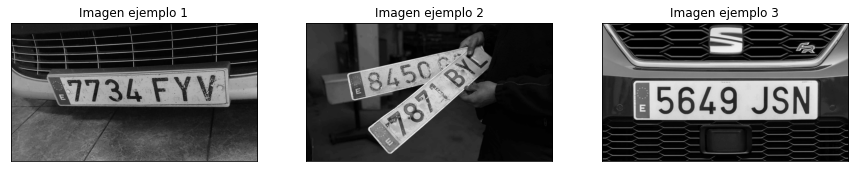

In [4]:
imshow_compare(matricula1,matricula2,matricula3)

# 3. Implementación

## Elemento estructural

A continuación se encuentra la función própia para construir el elemento estructural.

In [5]:
def elementoEstructural(radio,tipo):
    """
    Esta funcion devuelve un elemento estructural para utilizar en dilatacion y erosion
    radio: es el radio del elemento estructural
    tipo: es el tipo de elemento estructural, puede ser "cuadrado", "diamante" o "circulo"
    """
    elemento = np.zeros((radio*2+1,radio*2+1),dtype=int)
    if tipo == "cuadrado":
        for i in range(radio*2+1):
            for j in range(radio*2+1):
                elemento[i][j]=1
    elif tipo == "diamante":
        for i in range(radio*2+1):
            for j in range(radio*2+1):
                ij = abs(radio-i)+abs(radio-j)
                if ij <=radio:
                    elemento[i][j]=1
    elif tipo == "circulo":
        for i in range(radio*2+1):
            for j in range(radio*2+1):
                ij = np.sqrt((radio-i)*(radio-i)+(radio-j)*(radio-j))
                if ij <=radio:
                    elemento[i][j] = 1
    return elemento

## Erosión

A continuación se encuentra la función de erosión, el cual se ha realizado inspirandose en [1]:

In [6]:
# Función para comprobar que el indice no esta fuera de la imagen
def check_index_out(index):
    '''
    Comprueba que el indice no sea negativo
    index: Indice a comprobar
    '''
    if index < 0:
        return 0
    else:
        return index

def erosion_binaria(binary_image, SE):
    '''
    Aplica el operador morfologico erosión a una imagen previamente binarizada
    binary_image: Imagen binarizada. Valores de pixel a 0 (negro) o 255(blanco)
    SE: Es el elmento estructural mediante el cual aplicamos el operador
    Salida: Imagen erosionada. Valores de píxel a 0 (negro) o 1 (blanco)
    '''
    # Convertimos argumentos de entrada a numpy arrays
    binary_image = np.asarray(binary_image)
    SE = np.asarray(SE)
    # Dimensiones del elemento estrucutural
    SE_shape = SE.shape
    # Creamos matriz llena con 0 de dimensión de imagen de entrada para guardar la imagen erosionada
    eroded_img = np.zeros((binary_image.shape[0], binary_image.shape[1]))
    # Calculamos el centro del elemento estructural
    SE_origin = (int(np.ceil((SE.shape[0] - 1) / 2.0)), int(np.ceil((SE.shape[1] - 1) / 2.0)))
    # Iteramos para todos los pixeles de la imagen mediante dos bucles for (para filas y columnas)

    for i in range(0,binary_image.shape[0]):
        for j in range(0,binary_image.shape[1]):
            # Tomamos la región de pixeles de la imagen original que cubre el elemento estructural
            overlap = binary_image[check_index_out(i - SE_origin[0]):i + (SE_shape[0] - SE_origin[0]),check_index_out(j - SE_origin[1]):j + (SE_shape[1] - SE_origin[1])]
            # Dimensiones de la región del SE que cubre la imagen
            overlap_shape = overlap.shape
            # Obtenemos el índice del primer elemento del SE para filas y columnas
            if i - SE_origin[0] < 0:
                SE_first_row_index = int(np.fabs(i - SE_origin[0]))
            else:
                SE_first_row_index = 0
            if j - SE_origin[1] < 0:
                SE_first_col_index = int(np.fabs(j - SE_origin[1]))
            else:
                SE_first_col_index = 0
            # Obtenemos el índice del ultimo elemento del SE para filas y columnas
            if i + (SE_shape[0] - SE_origin[0]) > binary_image.shape[0]:
                SE_last_row_index = SE_shape[0] - 1 - (i + (SE_shape[0] - SE_origin[0]) - binary_image.shape[0])
            else: 
                SE_last_row_index = SE_shape[0]-1
            if j + (SE_shape[1] - SE_origin[1]) > binary_image.shape[1]:
                SE_last_col_index = SE_shape[1] - 1 - (j + (SE_shape[1] - SE_origin[1]) - binary_image.shape[1])
            else: 
                SE_last_col_index = SE_shape[1]-1
                
            # Realizamos operación AND entre overlap y SE. De esta forma detectamos los blancos (1) de la región de la imagen
            overlap_and_SE = np.logical_and(overlap, SE[SE_first_row_index:SE_last_row_index+1,SE_first_col_index:SE_last_col_index+1])
            # Comparamos el resultado de la operación anterior con el SE para ver si todos los pixeles son blancos o no
            check_is_white = np.array_equal(overlap_and_SE,SE[SE_first_row_index:SE_last_row_index+1,SE_first_col_index:SE_last_col_index+1])
            # En caso de que coincidan, rellenamos con blanco (1) el pixel de la imagen erosionada, sino se deja negro(0)
            if overlap_shape[0] != 0 and overlap_shape[1] != 0 and check_is_white:
                eroded_img[i,j] = 1
            # Se consigue así eliminar regiones blancas interiores a los números negros por ejemplo, además de engrosar los números negros sobre el fondo blanco de la matricula
    return eroded_img

## Función para añadir borde a la imagen

La siguiente función añade un borde en la imagen, se usa en la dilatación.

In [7]:
def imagenConBorde(imagen, n,valor=0):
    """
    Devuelve la misma imagen pero con un borde que es necesario en la dilatación
    imagen: la imagen a la que le pondremos borde
    n: el tamaño del borde que se aplicara en los cuatro lados, es decir una imagen de 200x300 con n=20 devolvera una imagen de 240x340.
    valor=0: El valor con el que vamos a rellenar el borde, en principio es negro (0)
    """
    height = imagen.shape[0]
    width = imagen.shape[1]
    # Creamos la nueva imagen con las nuevas dimensiones
    imagenConBorde = np.zeros((2*n+height,2*n+width),dtype=imagen.dtype)
    # Rellenamos con el valor
    imagenConBorde[n:height+n,n:width+n] = imagen.copy()
    # Copiamos la imagen original en el centro.
    return imagenConBorde

## Dilatación

A continuación se encuentra la función de la dilatación.

In [8]:
def dilatacion(imagen,elementoEstructural):
    """
    Aplica el operador morfologico dilatacion a una imagen en escala de grises
    imagen: Imagen original
    elementoEstructural: Es el elmento estructural mediante el cual aplicamos el operador
    """
    #Calculamos el borde que le vamos a poner a la imagen para que cuando 
    # aplicamos el elemento estructural no caiga fuera de la imagen.
    n = elementoEstructural.shape[0]//2
    imagenBorde = imagenConBorde(imagen,n)
    height = imagen.shape[0]
    width = imagen.shape[1]
    # Creamos una copia de la imagen
    output = np.zeros(imagen.shape,dtype=imagen.dtype)
    # Recorremos los pixeles de la imagen con el borde, pero solo los que no sean borde.
    for i in range(n,height+n):
        for j in range(n,width+n):
            # Aplicamos el maximo solo a los elemntos que no sean cero del elemetno estructural
            aux = np.multiply(imagenBorde[i-n:i+n+1,j-n:j+n+1],elementoEstructural)
            # Para realizar una erosion, se puede utilizar esta misma función cambiando max por min
            output[i-n][j-n] = np.max(aux) # Y se lo ponemos a la imagen de salida
    return output

## Binarización

El primer paso que se realiza en las imagenes es una binarización de ellas.

In [9]:
def binarizar(img, umbral = 127):
    '''
    Binariza la imagen
    img: imagen a binarizar
    umbral: valor tomado para hacer la diferenciación entre pixeles blancos y negros
    '''
    imagen = img.copy()
    width = imagen.shape[0]-1
    heigth = imagen.shape[1]-1
    for i in range(width):
        for j in range(heigth):
            if imagen[i][j]<=umbral:
                imagen[i][j]=0
            else:
                imagen[i][j]=255
    return imagen

A continuación se muestran las tres imagenes después de aplicar la binarización.

In [10]:
matricula1_bin = binarizar(matricula1)
matricula2_bin = binarizar(matricula2)
matricula3_bin = binarizar(matricula3)

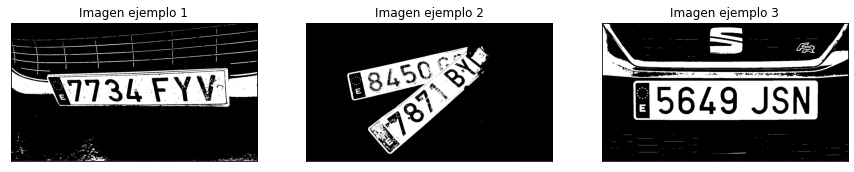

In [11]:
imshow_compare(matricula1_bin,matricula2_bin,matricula3_bin)

## Cierre

El primer filtro morfológico que se aplica es el de cierre, este consiste de una dilatación seguida de una erosión. Este filtro se aplica para poder eliminar los detalles negros más pequeños como puedan ser motas de polvo o desgastes en la parte blanca de la matrícula que podrían llegar a juntarse con los numeros en el próximo paso y terminar causano una mala detección al final del porceso.

Para este filtro de cierre se usará un operador morfológico de forma cuadrada y con la medida más pequeña de 1, ya que en este caso se pretenden eliminar solo pequeños detalles intentando mantener lo mejor possible los números de las matrículas.

In [12]:
def cierre(img, opMorf):
    """
    Aplica el filtro morfológico de cierre
    """
    dilat = dilatacion(img, opMorf)
    return erosion_binaria(dilat, opMorf)

operadorMorf = elementoEstructural(1,"cuadrado")

Se aplica el cierre en las tres imagenes y el resultado de este filtro se puede ver a continuación.

In [13]:
matricula1_cierre = cierre(matricula1_bin, operadorMorf)
matricula2_cierre = cierre(matricula2_bin, operadorMorf)
matricula3_cierre = cierre(matricula3_bin, operadorMorf)

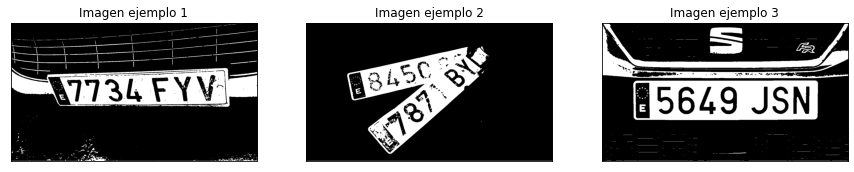

In [14]:
imshow_compare(matricula1_cierre,matricula2_cierre,matricula3_cierre)

Como se puede ver el filtro de cierre ha mejorado sobretodo la matrícula número 1, la cual tenía pequeños puntos negros que ahora ya no estan en ella. En las otras dos el efecto del filtro es poco apreciable.

## Apertura

El siguiente paso es el filtro morfológico de apertura, en el cual, se hace primero una erosión a la imagen y seguido se realiza una dilatación. El objetivo de este filtro morfológico es reconstruir los numeros que puedan estar desgastados para que en el próximo paso el filtro de Sobel pueda encontrar todos los bordes lo más correctos posible con pocos detalles dentro de los números.

A diferencia del cierre, en este caso se usará un operador morfológico mucho mayor, de 8, y de forma cuadrada ya que se quiere ampliar los números y estos tienen formas más bien cuadradas y con este operador se van a obtener buenos resultados. Es importante remarcar que para usar este operador será imprescindible que las matrículas sean de un tamaño considerable, sino se tendrá que reducir su tamaño.

In [15]:
def apertura(img, opMorf):
    """
    Filtro morfologico de apertura, como parametros tiene la imagen y el operador
    """
    eroded = erosion_binaria(img,opMorf)
    return dilatacion(eroded,opMorf)

operadorMorf = elementoEstructural(8,"cuadrado")

A continuación se aplica la apertura a las tres imágenes de ejemplo.

In [16]:
matricula1_apertura = apertura(matricula1_cierre, operadorMorf)
matricula2_apertura = apertura(matricula2_cierre, operadorMorf)
matricula3_apertura = apertura(matricula3_cierre, operadorMorf)

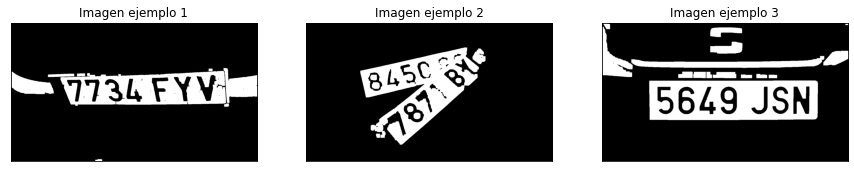

In [17]:
imshow_compare(matricula1_apertura,matricula2_apertura,matricula3_apertura)

Como se puede ver el filtro ha realizado un buen trabajo en general, en el caso de la imagen 1, dónde la letra V estaba desgastada, ahora esta totalmente recuperada, por otro lado, en la segunda imagen, el número 1 aún tiene un pequeño desgaste, pero ha mejorado respecto a la original. En el caso idóneo de la tercera matrícula ni el anterior filtro ni este han significado ningún cambio, esto es un aspecto positivo, ya que indica que para las matrículas que se ven bien, el filtro no las va a distorsionar.

## Filtro de Sobel

A continuación se muestra una implementación del filtro de Sobel. La función `sobel_edge_detection` te permite realizar distintos tipos de filtro Sobel. En términos generales, a partir de un kernel de sobel (matriz de coeficientes) la función realiza la convolución bidimensional de la imagen `image` con dicho kernel. Concretamente, puede filtrar con un kernel Sobel de tipo `gradiente y`, `gradiente x` y `magnitud`. El filtro de gradiente `x` es capaz de detectar los bordes verticales, en dicho caso el kernel distribuye sus coeficientes sobre la horizontal de la matriz. Por otro lado, el filtro de gradiente `y` es capaz de detectar los bordes horizontales, en dicho caso el kernel distribuye sus coeficientes sobre la vertical de la matriz. Por último, el filtro de sobel de tipo `magnitud` consiste en la raiz cuadrada de la suma de los cuadrados del resultado de los dos filtrados anteriores (gradiente y y gradiente x). En cada uno de los casos, el resultado del filtrado es normalizado por su máximo valor.


In [18]:
def sobel_edge_detection(image, vertical = False, horizontal = False, magnitude = False):
    vertical_filter = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]]) #Matriz de convolución
    horizontal_filter = np.flip(vertical_filter.T, axis=0)
    if vertical:
        result = cv2.filter2D(image, -1, vertical_filter)
        result = (result / result.max())
    elif horizontal:
        result = cv2.filter2D(image, -1, horizontal_filter)
        result = (result / result.max())
    elif magnitude:
        new_image_vertical = cv2.filter2D(image, -1, vertical_filter)
        new_image_horizontal = cv2.filter2D(image, -1, horizontal_filter)
        result = np.sqrt(np.square(new_image_horizontal) + np.square(new_image_vertical))
        result = np.array((result / result.max())*255.0, dtype=float)
    return result

Se decide realizar un último filtrado de tipo `Sobel magnitud` para enfatizar los bordes resultantes de las operaciones morfologicas. Esto ayuda a que módulos especializados en reconocimiento de carácteres ópticos puedan detectar mejor los contornos de los numeros y letras de la matrícula.

In [19]:
result_image1 = sobel_edge_detection(matricula1_apertura, magnitude = True)
result_image2 = sobel_edge_detection(matricula2_apertura, magnitude = True)
result_image3 = sobel_edge_detection(matricula3_apertura, magnitude = True)

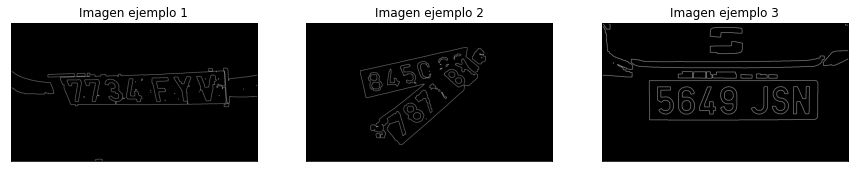

In [20]:
imshow_compare(result_image1,result_image2,result_image3)

En las imagenes superiores se puede apreciar el resultado del filtrado Sobel. En ellas, se muestra una considerable reducción de elementos ruidosos gracias a las operaciones morfológicas antes ejecutadas y un fuerte realzado de los bordes tanto verticales como horizontales debido a la aplicación del filtro Sobel Magnitud a la imagen. Se puede observar como los numeros y letras de la matrícula se encuentran perfectamente diferenciados en sus bordes internos como los externos, aunque cada una de ellas tiene ciertos detalles a ser comentados.

Para la primera imagen de ejemplo, aún se pueden apreciar ciertos puntos negros de suciedad en la zona blanca de la matrícula. En este caso, con un cierre más agresivo se hubieran tenido mejores resultados. Para ello, se podría haber usado un operador morfológico de medida 3.

En el segundo caso, la imagen tiene aún cierto ruido en el número 1, aunque ha mejorado bastante respecto a la imagen original. En este caso, podría haber sido necesario prescindir del cierre y hacer una apertura con un mayor operador morfológico.

Para la última imagen de ejemplo, esta salen todos los números perfectos, así que no haría falta realizar ningún cambio.

Los valores de operadores morfológicos han sido selecionados de tal manera que puedan ser lo más generalizables posible.

# 4. Conclusiones

A modo de comparación, se muestra el resultado de aplicar el filtro de Sobel en las imagenes originales sin ninguna operación morfológica para poder ver la importancia del proceso previo realizado.

In [21]:
image1 = sobel_edge_detection(matricula1, magnitude = True)
image2 = sobel_edge_detection(matricula2, magnitude = True)
image3 = sobel_edge_detection(matricula3, magnitude = True)

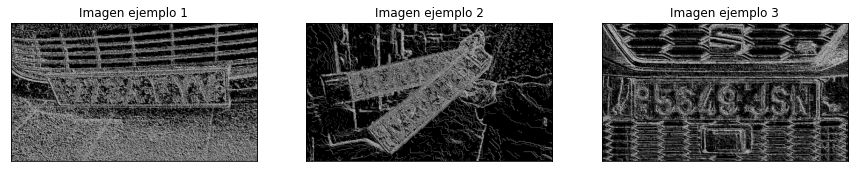

In [22]:
imshow_compare(image1,image2,image3)

Como se puede observar, con el filtro de Sobel aplicado a las imagenes originales se obienen resultados indeseados, y esto muestra que tanto la binarización como los filtros de cierre y apertura son esenciales para este tipo de aplicación.

La implementación del codigo completo ha usado ideas de como se realiza el preprocesado para leer los números de las matrículas de [3]. A diferencia de estos preprocesados, en este caso se han implementado todas las funciones sin utilizar librerías que las dan ya hechas. Un problema derivado de esto es que el tiempo de cómputo es mayor, pero al ser funciones própias, es más fácil de comprender el funcionamiento general y además si fuese necesario se podrían ajustar debidamente a los requerimientos.

Se puede considerar que la implementación principal en este caso es el filtrado general de las matrículas que se compone de tanto filtros morfológicos como un filtro espacial. A partir del punto de dónde termina el trabajo, seguiría la implementación de un programa para reconocer los números.

# 5. Referencias

[1] Sumbul, G. (2017). *Dilation and erosion morphological operations implementation.*
https://github.com/gencersumbul/sumbul_binary/blob/master/binary_operations.py

[2] Abhisek, J. (2019). *How to implement Sobel edge detection using Python from scratch.* A Developer Diary.
https://www.adeveloperdiary.com/data-science/computer-vision/how-to-implement-sobel-edge-detection-using-python-from-scratch/

[3] Rosebrock, A. (2020). *OpenCV: Automatic License/Number Plate Recognition (ANPR) with Python. PyImageSearch.* https://www.pyimagesearch.com/2020/09/21/opencv-automatic-license-number-plate-recognition-anpr-with-python/